## 소셜 네트워크 그래프에서의 머신러닝

In [3]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

6 장에서는 이전 장에서 설명한 기술을 사용해 오늘날 그래프의 가장 일반적인 예인 소셜 네트워크를 분석하는 데 중점을 둔다.
특히 우리는 이전 장에서 설명한 기술을 적용해 다음과 같은 네트워크의 토폴로지 속성을 조사할 것이다.
1. 관련 커뮤니티 식별
2. 네트워크에서 중요한 노드 식별

그리고 노드 임베딩을 사용해 링크 예측(새 친구를 위한 잠재적 추천 엔진)과 같은 다양한 작업에 대한 토폴로지 정보의 힘을 활용할 것이다.

#### 데이터셋 다운로드

먼저 데이터 세트를 다운로드 해야한다. [SNAP 페이스북 소셜 그래프](http://snap.stanford.edu)를 사용할 것이다. 해당 데이터셋은 설문 참여자로부터 페이스북 사용자 정보를 수집해 만들어졌다. 좀 더 자세히 설명하면, 10명의 사용자로부터 10개의 에고 네트워크를 생성한다. 각 사용자는 친구가 속한 모든 서클(친구 목록)을 식별하도록 요청받았고, 이러한 모든 "에고 네트워크"가 단일 그래프에 결합되어있다.

In [ ]:
# Linux
!wget http://snap.stanford.edu/data/facebook_combined.txt.gz
!wget http://snap.stanford.edu/data/facebook.tar.gz
!gzip -d facebook_combined.txt.gz
!tar -xf facebook.tar.gz

# Windows 사용자는 웹 브라우저에서 해당 링크를 접속하여 다운로드 후 압축 해제

### 데이터셋 개요

위의 코드는 두 개의 기본 파일을 다운로드합니다.
* 그래프의 간선 목록을 포함하는 텍스트 파일(그래프가 실제로 생성됨)
* 각 에고 네트워크와 관련된 모든 정보가 포함된 폴더("facebook")를 포함하는 아카이브

In [ ]:
# 다운로드 내용 확인
# Linux
!ls
# Windows
!dir

In [4]:
# 간선 목록의 첫번째 줄 확인
with open("./facebook_combined.txt") as f:
    line = f.readlines(1)
print(line[0])

0 1



이제 networkx를 사용해 결합된 네트워크를 로드할 수 있다. "ego-user"의 nodeId도 로드한다.

In [5]:
G = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
# "facebook" 디렉토리의 각 파일 이름은 nodeId.format으로 지정되어 있다.
# 여기서 nodeId는 에고 사용자의 ID이고 형식은 파일의 형식이다.
ego_nodes = set([int(name.split('.')[0]) for name in os.listdir("facebook/")])

더 깊은 이해를 위해 네트워크를 시각화하자

In [8]:
#시각화를 위한 네트워크 레이아웃 생성
spring_pos = nx.spring_layout(G)

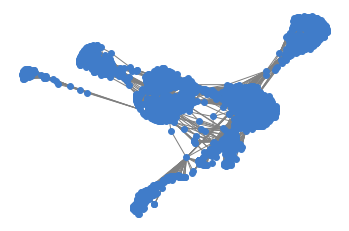

In [9]:
plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, node_color=default_node_color, edge_color=default_edge_color, with_labels=False, node_size=35)

### Network Analysis

In [10]:
def draw_metric(G, dct, spring_pos):
  """ spring_pos 레이아웃을 사용하여 그래프 G를 그린다.
      상위 10개 노드의 w.r.t. 값을 강조시켰다. """
  top = 10
  max_nodes =  sorted(dct.items(), key = lambda v: -v[1])[:top]
  
  max_keys = [key for key,_ in max_nodes]
  max_vals = [val*300 for _, val in max_nodes]

  plt.axis("off")
  
  nx.draw_networkx(G, 
                   pos=spring_pos, 
                   cmap='Blues', 
                   edge_color=default_edge_color,
                   node_color=default_node_color, 
                   node_size=3,
                   alpha=0.4, 
                   with_labels=False)
  
  nx.draw_networkx_nodes(G, 
                         pos=spring_pos, 
                         nodelist=max_keys, 
                         node_color=enhanced_edge_color,
                         node_size=max_vals)

In [11]:
# 매개 중심성
bC = nx.betweenness_centrality(G)
np.mean(list(bC.values()))

0.0006669573568730229

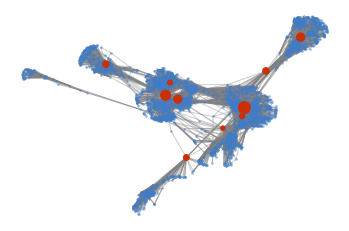

In [12]:
draw_metric(G,bC,spring_pos)

In [13]:
# 전역 효율성
gE = nx.global_efficiency(G)
print(gE)

0.30657814798734856


In [14]:
# 평균 클러스터링
aC = nx.average_clustering(G)
print(aC)

0.6055467186200876


In [15]:
# 연결 중심성
deg_C = nx.degree_centrality(G)
np.mean(list(deg_C.values()))

0.010819963503439287

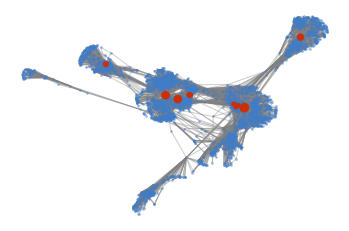

In [16]:
draw_metric(G,deg_C,spring_pos)

In [17]:
# 근접 중심성
clos_C = nx.closeness_centrality(G)
np.mean(list(clos_C.values()))

0.2761677635668376

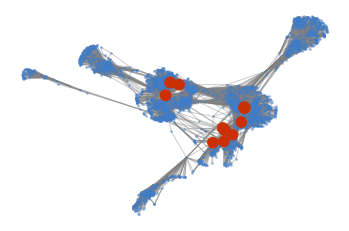

In [18]:
draw_metric(G,clos_C,spring_pos)

In [19]:
# 동류성
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

0.06357722918564664

In [20]:
t = nx.transitivity(G)
t

0.5191742775433075

In [ ]:
#import networkx.algorithms.community as nx_comm
#nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

#### 커뮤니티 감지
아래 셀의 코드로 네트워크 토폴로지의 정보를 사용해 커뮤니티를 자동으로 감지할 수 있다.

0 is in community number 0
107 is in community number 3
3980 is in community number 12
3437 is in community number 8
686 is in community number 13
1684 is in community number 5
1912 is in community number 4
698 is in community number 13
348 is in community number 1
414 is in community number 1


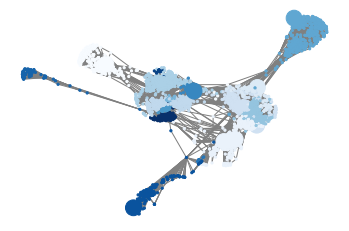

In [34]:
import community

parts = community.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

for node in ego_nodes:
  print(node, "is in community number", parts.get(node))
  
n_sizes = [5]*len(G.nodes())
for node in ego_nodes:
  n_sizes[node] = 250

plt.axis("off")
nx.draw_networkx(G, pos=spring_pos, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=n_sizes, with_labels=False)

0 is in community number 0
107 is in community number 2
3980 is in community number 13
3437 is in community number 15
686 is in community number 14
1684 is in community number 4
1912 is in community number 3
698 is in community number 14
348 is in community number 1
414 is in community number 1


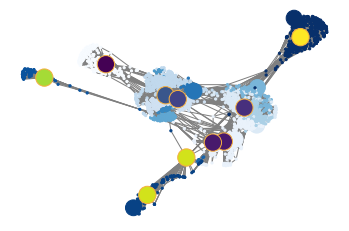

In [21]:
# 에고 노드의 색상 및 크기 강조
nodes = nx.draw_networkx_nodes(G,spring_pos,ego_nodes,node_color=[parts.get(node) for node in ego_nodes])
nodes.set_edgecolor(enhanced_node_color)

### 에고 네트워크 분석

여기서 분석하고 있는 결합된 네트워크는 실제로 10개의 하위 네트워크(에고 네트워크)로 구성되어 있기 때문에, 모든 하위 네트워크를 확인해 보는 것이 좋다. 다음 셀에서 에고 사용자 "0"의 하위 네트워크를 분석한다.

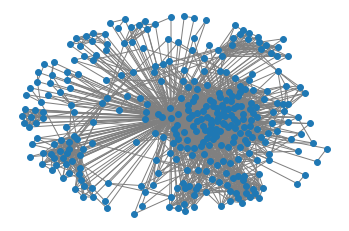

In [22]:
G0 = nx.read_edgelist("facebook/0.edges", create_using=nx.Graph(), nodetype=int)
for node in G0.copy():
  G0.add_edge(0,node)

plt.axis("off")
pos_G0 = nx.spring_layout(G0)
nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, edge_color=default_edge_color)

각 서브네트워크에 속한 노드는 nodeId.circles라는 이름으로 "facebook" 폴더에 저장된다.

In [23]:
import pandas as pd
circles = {}

with open("facebook/0.circles") as f_in:
  line = f_in.readline().rstrip().split("\t")
  while line and not '' in line:
    circles[line[0]] = [int(v) for v in line[1:]]
    line = f_in.readline().rstrip().split("\t")

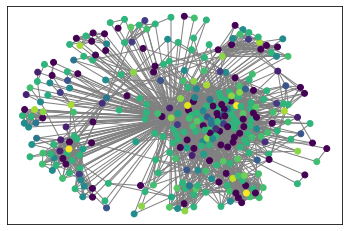

In [24]:
node_colors = [0] * G0.number_of_nodes()
count = 0
for key in circles:
  circle = circles[key]
  for node in circle:
    if node < G0.number_of_nodes():
      node_colors[node] = count
  count += 1

nx.draw_networkx(G0, pos=pos_G0, with_labels=False, node_size=35, node_color=node_colors, edge_color=default_edge_color)

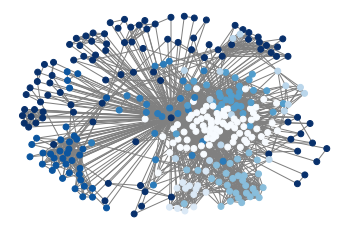

In [25]:
parts = community.best_partition(G0)
values = [parts.get(node) for node in G0.nodes()]

plt.axis("off")
nx.draw_networkx(G0, pos=pos_G0, cmap=plt.get_cmap("Blues"), edge_color=default_edge_color, node_color=values, node_size=35, with_labels=False)

In [26]:
# 위에서 발견한 커뮤니티는 서클을 반영하지 않는다.
set(parts.values())
len(circles)

24

In [27]:
# 노드가 둘 이상의 목록에 존재 할 수 있을까?
for i in circles:
  for j in circles:
    if i != j:
      for n1 in circles[i]:
        for n2 in circles[j]:
          if n1 == n2:
            print(n1, 'present in ',i,'found in', j)
            assert(False)  # For 문 전체 종료 (AssertionError)

54 present in  circle0 found in circle11


AssertionError: 

In [28]:
#@title  
nx.average_shortest_path_length(G0)
nx.global_efficiency(G0)
nx.average_clustering(G0)

np.mean(list(nx.betweenness_centrality(G0).values()))
np.mean(list(nx.closeness_centrality(G0).values()))
np.mean(list(nx.degree_centrality(G0).values()))
nx.degree_pearson_correlation_coefficient(G)
nx.transitivity(G)

import networkx.algorithms.community as nx_comm
nx_comm.modularity(G, nx_comm.label_propagation_communities(G))

0.7368407345343148

### 지도 및 비지도 작업에 대한 임베딩

이제 페이스북 소셜 그래프에 대한 간선 예측에 대한 실제 머신러닝 작업을 진행한다.

#### 노드 특징 분석

먼저 각 노드를 설명하는 모든 특징을 로드한다. 각 하위 네트워크의 고유한 특징 세트는 이름과 값이 다른 파일에 저장되어있기 때문에 이를 위한 간단한 코드가 필요하다.

In [29]:
# https://github.com/jcatw/snap-facebook에서 수정

feat_file_name = "feature_map.txt"
feature_index = {}  #numeric index to name
inverted_feature_index = {} #name to numeric index
network = nx.Graph()

def parse_featname_line(line):
  """ 특징 이름을 포함하는 파일의 각 줄을 구문 분석하는 데 사용한다. """
  line = line[(line.find(' '))+1:]  # chop first field
  split = line.split(';')
  name = ';'.join(split[:-1]) # feature name
  index = int(split[-1].split(" ")[-1]) #feature index
  return index, name

def load_features():
  """ 
  각 자아 네트워크를 구문 분석하고 두 개의 파이썬 dict를 만든다.
       - feature_index: 숫자 인덱스를 이름에 매핑
       - inverted_feature_index: 이름을 숫자 인덱스에 매핑
  """
  import glob
  feat_file_name = 'tmp.txt'
  # 인덱스를 먼저 빌드해야 할 수도 있음
  if not os.path.exists(feat_file_name):
      feat_index = {}
      # data/*.featnames 파일에서 인덱스 빌드
      featname_files = glob.iglob("facebook/*.featnames")
      for featname_file_name in featname_files:
          featname_file = open(featname_file_name, 'r')
          for line in featname_file:
              # 예시:
              # 0 birthday;anonymized feature 376
              index, name = parse_featname_line(line)
              feat_index[index] = name
          featname_file.close()
      keys = feat_index.keys()
      keys = sorted(keys)
      out = open(feat_file_name,'w')
      for key in keys:
          out.write("%d %s\n" % (key, feat_index[key]))
      out.close()

  index_file = open(feat_file_name,'r')
  for line in index_file:
      split = line.strip().split(' ')
      key = int(split[0])
      val = split[1]
      feature_index[key] = val
  index_file.close()

  for key in feature_index.keys():
      val = feature_index[key]
      inverted_feature_index[val] = key

def parse_nodes(network, ego_nodes):
  """
  네트워크의 각 노드에 대해 load_features 함수를 사용해
  이전에 로드한 해당 특징을 할당한다.
  """
  # 각 노드를 구문 분석
  for node_id in ego_nodes:
      featname_file = open(f'facebook/{node_id}.featnames','r')
      feat_file     = open(f'facebook/{node_id}.feat','r')
      egofeat_file  = open(f'facebook/{node_id}.egofeat','r')
      edge_file     = open(f'facebook/{node_id}.edges','r')

      ego_features = [int(x) for x in egofeat_file.readline().split(' ')]

      # 에고 노드 특징 추가
      network.nodes[node_id]['features'] = np.zeros(len(feature_index))
      
      # 에고 노드 구문 분석
      i = 0
      for line in featname_file:
          key, val = parse_featname_line(line)
          # 필요에 따라 특징값 업데이트
          if ego_features[i] + 1 > network.nodes[node_id]['features'][key]:
              network.nodes[node_id]['features'][key] = ego_features[i] + 1
          i += 1

      # 이웃 노드 구문 분석
      for line in feat_file:
          featname_file.seek(0)
          split = [int(x) for x in line.split(' ')]
          node_id = split[0]
          features = split[1:]

          # 노드 특징 추가
          network.nodes[node_id]['features'] = np.zeros(len(feature_index))

          i = 0
          for line in featname_file:
              key, val = parse_featname_line(line)
              # 필요에 따라 특징값 업데이트
              if features[i] + 1 > network.nodes[node_id]['features'][key]:
                  network.nodes[node_id]['features'][key] = features[i] + 1
              i += 1
          
      featname_file.close()
      feat_file.close()
      egofeat_file.close()
      edge_file.close()

In [30]:
# 간선 특징을 구문 분석하고 networkx 노드에 추가
load_features()
parse_nodes(G, ego_nodes)

In [31]:
# 특징이 올바르게 할당되었는지 확인
G.nodes[0]

{'features': array([1., 1., 1., ..., 0., 0., 0.])}

### 링크 예측
이제 머닝러닝을 진행 할 것이다.
먼저 stellargraph 유틸리티 함수를 사용하여 훈련 및 테스트 셋을 정의한다.

In [ ]:
!pip install stellargraph
!pip install node2vec==0.3.3
!pip install git+https://github.com/palash1992/GEM.git

In [32]:
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

edgeSplitter = EdgeSplitter(G) 
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

edgeSplitter = EdgeSplitter(graph_test, G) 
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)

** Sampled 8823 positive and 8823 negative edges. **
** Sampled 7941 positive and 7941 negative edges. **


누락된 간선을 예측하는 세 가지 다른 방법을 비교할 것이다.
- 방법 1: node2vec는 노드 임베딩을 학습하고, 이러한 임베딩을 지도 방식으로 랜덤 포레스트 분류기를 훈련하는 데 사용한다.
- 방법 2: graphSAGE(특징을 포함하거나 제외시킨 2가지 방법으로)를 링크 예측에 사용한다.
- 방법 3: 수작업 특징을 추출하여 Random Forest 분류기를 훈련하는 데 사용한다.

##### node2vec


In [33]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 
from stellargraph.data import EdgeSplitter 

node2vec = Node2Vec(graph_train) 
model = node2vec.fit() 
edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

edges_embs = HadamardEmbedder(keyed_vectors=model.wv) 
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.75s/it]


In [35]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(n_estimators=10) 
rf.fit(train_embeddings, labels_train); 
 
y_pred = rf.predict(test_embeddings) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.9657596371882086
Recall: 0.9654312592088858
F1-Score: 0.9655954202799977


##### graphSAGE

In [36]:
# graphSAGE 특징 제외 버전

In [37]:
eye = np.eye(graph_train.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_train, fake_features, "fake")

eye = np.eye(graph_test.number_of_nodes())
fake_features = {n:eye[n] for n in G.nodes()}
nx.set_node_attributes(graph_test, fake_features, "fake")

In [38]:
graph_train.nodes[0]

{'features': array([1., 1., 1., ..., 0., 0., 0.]),
 'fake': array([1., 0., 0., ..., 0., 0., 0.])}

In [39]:
from stellargraph.mapper import GraphSAGELinkGenerator

batch_size = 64
num_samples = [4, 4]

sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="fake")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="fake")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [40]:
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras

layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [41]:
epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

Epoch 1/10
249/249 [==============================] - 28s 114ms/step - loss: 0.2311 - acc: 0.6021 - val_loss: 0.1914 - val_acc: 0.7219
Epoch 2/10
249/249 [==============================] - 26s 105ms/step - loss: 0.1959 - acc: 0.7208 - val_loss: 0.1836 - val_acc: 0.7386
Epoch 3/10
249/249 [==============================] - 26s 106ms/step - loss: 0.1873 - acc: 0.7429 - val_loss: 0.1788 - val_acc: 0.7514
Epoch 4/10
249/249 [==============================] - 26s 106ms/step - loss: 0.1806 - acc: 0.7632 - val_loss: 0.1747 - val_acc: 0.7666
Epoch 5/10
249/249 [==============================] - 26s 106ms/step - loss: 0.1768 - acc: 0.7768 - val_loss: 0.1731 - val_acc: 0.7756
Epoch 6/10
249/249 [==============================] - 26s 105ms/step - loss: 0.1737 - acc: 0.7881 - val_loss: 0.1724 - val_acc: 0.7776
Epoch 7/10
249/249 [==============================] - 26s 106ms/step - loss: 0.1725 - acc: 0.7924 - val_loss: 0.1721 - val_acc: 0.7835
Epoch 8/10
249/249 [==============================] - 2

In [42]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print('Precision:', metrics.precision_score(labels_train, y_pred)) 
print('Recall:', metrics.recall_score(labels_train, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_train, y_pred))

Precision: 0.5058052434456929
Recall: 0.6802669688956051
F1-Score: 0.5802051447290693


In [43]:
y_pred = np.round(model.predict(test_flow)).flatten()
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.7162767951748309
Recall: 0.9960330953190525
F1-Score: 0.8333017257728048


In [44]:
# graphSAGE 특징 포함

In [45]:
sg_graph_train = StellarGraph.from_networkx(graph_train, node_features="features")
sg_graph_test = StellarGraph.from_networkx(graph_test, node_features="features")

train_gen = GraphSAGELinkGenerator(sg_graph_train, batch_size, num_samples)
train_flow = train_gen.flow(samples_train, labels_train, shuffle=True, seed=24)

test_gen = GraphSAGELinkGenerator(sg_graph_test, batch_size, num_samples)
test_flow = test_gen.flow(samples_test, labels_test, seed=24)

In [46]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

epochs = 10
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

link_classification: using 'ip' method to combine node embeddings into edge embeddings
Epoch 1/10
249/249 [==============================] - 15s 62ms/step - loss: 0.1778 - acc: 0.8263 - val_loss: 0.1670 - val_acc: 0.8737
Epoch 2/10
249/249 [==============================] - 15s 61ms/step - loss: 0.1710 - acc: 0.8566 - val_loss: 0.1668 - val_acc: 0.8550
Epoch 3/10
249/249 [==============================] - 15s 60ms/step - loss: 0.1687 - acc: 0.8484 - val_loss: 0.1666 - val_acc: 0.8660
Epoch 4/10
249/249 [==============================] - 15s 60ms/step - loss: 0.1675 - acc: 0.8585 - val_loss: 0.1664 - val_acc: 0.8640
Epoch 5/10
249/249 [==============================] - 15s 60ms/step - loss: 0.1669 - acc: 0.8635 - val_loss: 0.1667 - val_acc: 0.8651
Epoch 6/10
249/249 [==============================] - 15s 60ms/step - loss: 0.1662 - acc: 0.8591 - val_loss: 0.1664 - val_acc: 0.8675
Epoch 7/10
249/249 [==============================] - 15s 61ms/step - loss: 0.1661 - acc: 0.8714 - val_loss: 

In [47]:
from sklearn import metrics 
y_pred = np.round(model.predict(train_flow)).flatten()
print('Precision:', metrics.precision_score(labels_train, y_pred)) 
print('Recall:', metrics.recall_score(labels_train, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_train, y_pred)) 

Precision: 0.5027367551378705
Recall: 0.6130210300969651
F1-Score: 0.5524285065819337


In [48]:
y_pred = np.round(model.predict(test_flow)).flatten()
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.8104051565377532
Recall: 0.9975065170576901
F1-Score: 0.8942742468119698


#### 수작업 특징

In [49]:
import community

def get_shortest_path(G,u,v):
  """ 간선이 없는 상태를 가정한 두 노드 (u,v) 사이의
      최단 경로 길이를 반환한다. """
  removed = False
  if G.has_edge(u,v):
    removed = True
    G.remove_edge(u,v) # 간선 임시 삭제
  
  try:
    sp = len(nx.shortest_path(G, u, v))
  except:
    sp = 0

  if removed:
    G.add_edge(u,v) # 삭제한 간선 다시 추가

  return sp

def get_hc_features(G, samples_edges, labels):
  # 측정 지표 미리 계산
  centralities = nx.degree_centrality(G)
  parts = community.best_partition(G)
  
  feats = []
  for (u,v),l in zip(samples_edges, labels):
    shortest_path = get_shortest_path(G, u, v)
    j_coefficient = next(nx.jaccard_coefficient(G, ebunch=[(u, v)]))[-1]
    u_centrality = centralities[u]
    v_centrality = centralities[v]
    u_community = parts.get(u)
    v_community = parts.get(v)
    # add the feature vector
    feats += [[shortest_path, j_coefficient, u_centrality, v_centrality]]
  return feats

feat_train = get_hc_features(graph_train, samples_train, labels_train)
feat_test = get_hc_features(graph_test, samples_test, labels_test)

In [50]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

rf = RandomForestClassifier(n_estimators=10) 
rf.fit(feat_train, labels_train); 
 
y_pred = rf.predict(feat_test) 
print('Precision:', metrics.precision_score(labels_test, y_pred)) 
print('Recall:', metrics.recall_score(labels_test, y_pred)) 
print('F1-Score:', metrics.f1_score(labels_test, y_pred)) 

Precision: 0.96494960806271
Recall: 0.9766519324492803
F1-Score: 0.9707655044217879
